# Pruebas de NN con datos de telecom


In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.utils import to_categorical
import tensorview as tv
from tensorflow.keras import losses, metrics,  optimizers, regularizers

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split,ParameterGrid
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import pydotplus
import matplotlib.image as mpimg


## Cargar Datos a partir de un archivo CSV 

In [2]:
df = pd.read_csv('~/Desktop/MLandPython/dataset archive/teleCust1000t.csv')
print(df.shape)
df.head()
#df['custcat'].value_counts()

(1000, 12)


,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3


## Definimos X e y 

In [3]:
## Quito features para intentar bajar la varianza 
vars_dep = ['region','tenure','marital','income', 'ed', 'retire','gender', 'reside']

X = df[vars_dep].values
X.shape

(1000, 8)

In [4]:
## Defino la y
y_label = df.columns[-1]
classes_nb = len(df[y_label].unique())
print(classes_nb, 'clases\n')

y = df[y_label]
print(y.shape)
y.unique()

4 clases

(1000,)


array([1, 4, 3, 2])

## Codificamos la variable de salida
Lo hacemos adaptando a una red neuronal con 1 neurona de salida por cada clase en clasificación

One Hot Encoding

In [5]:
## Encode class values as integers (LabelEncoder)
## Convert integers to dummy variables (OneHotEncoder)
ohe = OneHotEncoder(sparse = False)
le = LabelEncoder()

dummy_y = le.fit_transform(y)
dummy_y = ohe.fit_transform(dummy_y.reshape(-1, 1))
dummy_y[0:10]

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]])

In [6]:
# # Con esto se revierten las codificaciones, puedo usarlo con la prediccion
# alreves = ohe.inverse_transform(y)
# alreves = alreves.reshape(1,-1)[0,:]
# alreves = le.inverse_transform(alreves)
# alreves

## Normalizar los Datos 

In [7]:
# Si el resultado es peor no lo hago
#X = MinMaxScaler().fit(X).transform(X.astype(float))
X = StandardScaler().fit(X).transform(X.astype(float))
X[0:5]


array([[-0.02696767, -1.055125  ,  1.0100505 , -0.12650641,  1.0877526 ,
        -0.22207644, -1.03459817, -0.23065004],
       [ 1.19883553, -1.14880563,  1.0100505 ,  0.54644972,  1.9062271 ,
        -0.22207644, -1.03459817,  2.55666158],
       [ 1.19883553,  1.52109247,  1.0100505 ,  0.35951747, -1.36767088,
        -0.22207644,  0.96655883, -0.23065004],
       [-0.02696767, -0.11831864, -0.9900495 , -0.41625141, -0.54919639,
        -0.22207644,  0.96655883, -0.92747794],
       [-0.02696767, -0.58672182,  1.0100505 , -0.44429125, -1.36767088,
        -0.22207644, -1.03459817,  1.16300577]])

## Aqui separo los datos en train y test


In [25]:
X_train, X_test, y_train, y_test = train_test_split( X, dummy_y, test_size=0.2, random_state=3)
print ('Set de Entrenamiento:', X_train.shape,  y_train.shape)
print ('Set de Prueba:', X_test.shape,  y_test.shape)
X_train.shape

Set de Entrenamiento: (800, 8) (800, 4)
Set de Prueba: (200, 8) (200, 4)


(800, 8)

## Creo función para crear una NN de L capas y N neuronas

Por defecto crea NN de 1 capa, relu y softmax de activación entrada y salida

In [26]:
def crea_red_Lcapas(capas=1, neuronas=32, activ_entr='relu', activ_hid='relu', activ_sal='softmax',
                 optimiser_mio='adam',epochs_ini=100, batch_ini=len(X_train)):
    
    metricNames = ['Categorical cross-entropy', 'Accuracy'] #'sparse_categorical_crossentropy'
    metricNamesRaw = ['loss', 'accuracy']
    
    model = Sequential()
    
    # Capa de entrada
    model.add(Dense(neuronas, input_dim = X_train.shape[1], activation=activ_entr))
    # Capas ocultas
    for i in range(1,capas):
        model.add(Dense(neuronas, activation=activ_hid))
    # Capa de salida    
    model.add(Dense(classes_nb, activation = activ_sal)) 
    model.compile(optimizer = optimiser_mio, loss='categorical_crossentropy', metrics=['accuracy']) 
    
    #Hago el entrenamiento/fit mostrando precision entren y test
    tvPlot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,cell_size=(6,4), columns=2, iter_num=epochs_ini, wait_num=2)
    historyDense0 = model.fit(X_train, y_train,
                    epochs=epochs_ini, batch_size=batch_ini, 
                    validation_data = (X_test, y_test), 
                    verbose=0,
                    #class_weight = class_weight,
                    callbacks=[tvPlot]);
    return model

## Creo la NN de las capas que quiero, la entreno y evalúo


In [113]:
#Defino la variables a estudiar: capas, neuronas, epochs y batch size
L=5
N=64
ep=100
bat=32

### Uso un GRID de hiperparámetros

No lo hago con todos a la vez. Primero busco los epochs y batch optimos y luego con ellos el resto.

El gráfico solo muestra el ultimo conjunto de parámetros

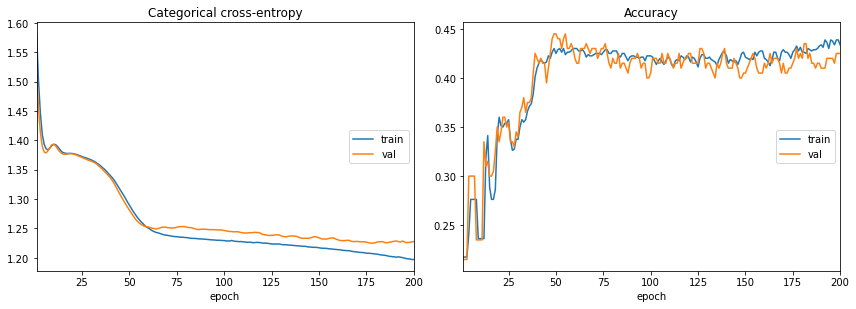

7/7 [==============================] - 0s 2ms/step - loss: 1.2277 - accuracy: 0.4250
Modelo: {'activ_entr': 'selu', 'activ_hid': 'sigmoid', 'activ_sal': 'softmax', 'batch_ini': 512, 'epochs_ini': 200, 'optimiser_mio': 'adam'} ✓


In [100]:
## Optimizo los hiperparámetros
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid({
                'epochs_ini':[15, 25, 50, 100, 200],
                 'batch_ini':[16, 32, 64, 128, 256 , 512], 
                 'activ_entr': ['relu', 'selu', 'tanh'],
                 'activ_hid'   : ['relu', 'sigmoid'],
                 'activ_sal'   : ['softmax'],
                 'optimiser_mio'   : ['adam']
                })

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'accuracy': []}

for params in param_grid:
    
    model = crea_red_Lcapas(capas=L, neuronas=N, 
                            #epochs_ini=ep , batch_ini=bat,
                            **params)
    test_loss, test_acc = model.evaluate(X_test, y_test)
    
    resultados['params'].append(params)
    resultados['accuracy'].append(test_acc)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados = resultados.reset_index(drop=True)

In [102]:
resultados.head(7)

In [103]:
# # Entreno el modelo final con los parámetros mejores que 
# model = crea_red_Lcapas(capas=L,
#                         neuronas=N,
#                         activ_entr = resultados.at[0,'activ_entr'],
#                         activ_hid = resultados.at[0,'activ_hid'],
#                         activ_sal = resultados.at[0,'activ_sal'],
#                         optimiser_mio = resultados.at[0,'optimiser_mio'],
#                         epochs_ini=ep, 
#                         batch_ini=bat)
# # Evaluacion del modelo para ambos
  

## Esta es la mejor red de 1 capa, con 8 neuronas

Ya sobrepasa la precisión del mejor de los métodos tradicionales, que era de un 43% para el KNN

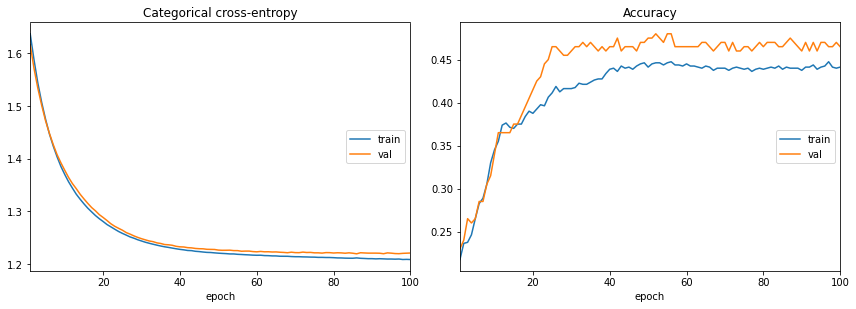


Precisión de entrenamiento:  0.44125
Precisión de test:  0.465


In [104]:
model = crea_red_Lcapas(capas=1,
                        neuronas=8,
                        activ_entr = 'tanh',
                        activ_hid = 'sigmoid',
                        activ_sal = 'softmax',
                        optimiser_mio = 'adam',
                        epochs_ini=100, 
                        batch_ini=32)

dummy_ypred = model.predict(X_train)
dummy_yhat = model.predict(X_test)
print("\nPrecisión de entrenamiento: ", accuracy_score(np.argmax(y_train, axis=1), np.argmax(dummy_ypred, axis=1)))
print("Precisión de test: ", accuracy_score(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1)))

In [106]:
#Matriz del modelo
print("Modelo de ",L," capas", N, "neuronas\n")
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1), labels=range(0,classes_nb)))
print (classification_report(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1)))


Modelo de  1  capas 8 neuronas

[[29  2 11  8]
 [ 8 16  9 10]
 [19  5 30  6]
 [12  8  9 18]]
              precision    recall  f1-score   support

           0       0.43      0.58      0.49        50
           1       0.52      0.37      0.43        43
           2       0.51      0.50      0.50        60
           3       0.43      0.38      0.40        47

    accuracy                           0.47       200
   macro avg       0.47      0.46      0.46       200
weighted avg       0.47      0.47      0.46       200



In [107]:
# Resumen del modelo
print(model.summary())

Model: "sequential_201"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_782 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_783 (Dense)            (None, 4)                 36        
Total params: 108
Trainable params: 108
Non-trainable params: 0
_________________________________________________________________
None


## Esta es la mejor red de 3 capas, con 32 neuronas

Se logra un poco mejor precisión pero varía un poco según la iteración.

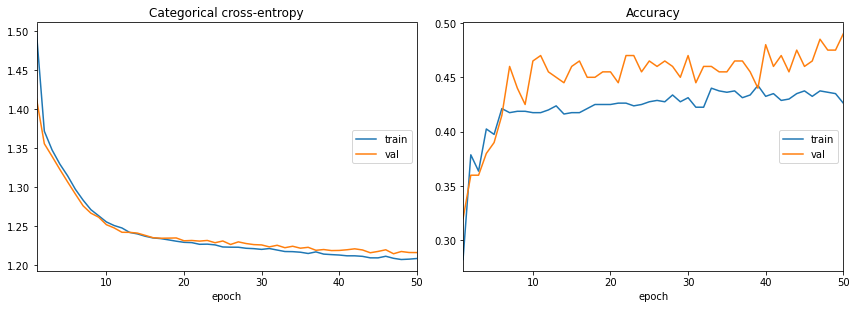


Precisión de entrenamiento:  0.42625
Precisión de test:  0.49


In [108]:
model = crea_red_Lcapas(capas=3,
                        neuronas=32,
                        activ_entr = 'selu',
                        activ_hid = 'sigmoid',
                        activ_sal = 'softmax',
                        optimiser_mio = 'adam',
                        epochs_ini=50, 
                        batch_ini=32)

dummy_ypred = model.predict(X_train)
dummy_yhat = model.predict(X_test)
print("\nPrecisión de entrenamiento: ", accuracy_score(np.argmax(y_train, axis=1), np.argmax(dummy_ypred, axis=1)))
print("Precisión de test: ", accuracy_score(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1)))

In [110]:
#Matriz del modelo
print("Modelo de ",L," capas", N, "neuronas\n")
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1), labels=range(0,classes_nb)))
print (classification_report(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1)))


Modelo de  3  capas 32 neuronas

[[30  2 10  8]
 [ 7 20  8  8]
 [18  7 30  5]
 [10  8 11 18]]
              precision    recall  f1-score   support

           0       0.46      0.60      0.52        50
           1       0.54      0.47      0.50        43
           2       0.51      0.50      0.50        60
           3       0.46      0.38      0.42        47

    accuracy                           0.49       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.49      0.49      0.49       200



In [111]:
# Resumen del modelo
print(model.summary())

Model: "sequential_202"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_784 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_785 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_786 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_787 (Dense)            (None, 4)                 132       
Total params: 2,532
Trainable params: 2,532
Non-trainable params: 0
_________________________________________________________________
None


## Esta es la mejor red de 5 capas, con 64 neuronas

Ya no se consigue mejor precisión aunque se aumenten las capas y las neuronas.

El modelo pasa a estar sobredimensionado y la red solo hace crecer el overfit.

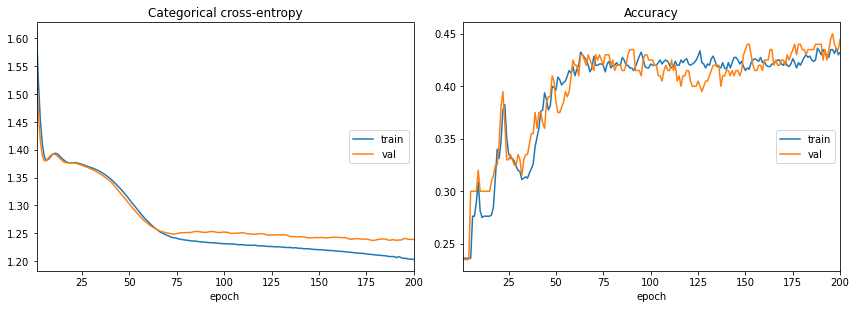


Precisión de entrenamiento:  0.42875
Precisión de test:  0.445


In [112]:
model = crea_red_Lcapas(capas=5,
                        neuronas=64,
                        activ_entr = 'selu',
                        activ_hid = 'sigmoid',
                        activ_sal = 'softmax',
                        optimiser_mio = 'adam',
                        epochs_ini=200, 
                        batch_ini=512)

dummy_ypred = model.predict(X_train)
dummy_yhat = model.predict(X_test)
print("\nPrecisión de entrenamiento: ", accuracy_score(np.argmax(y_train, axis=1), np.argmax(dummy_ypred, axis=1)))
print("Precisión de test: ", accuracy_score(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1)))

In [114]:
#Matriz del modelo
print("Modelo de ",L," capas", N, "neuronas\n")
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1), labels=range(0,classes_nb)))
print (classification_report(np.argmax(y_test, axis=1), np.argmax(dummy_yhat, axis=1)))


Modelo de  5  capas 64 neuronas

[[36  2  5  7]
 [ 9 14 10 10]
 [24  7 23  6]
 [13 11  7 16]]
              precision    recall  f1-score   support

           0       0.44      0.72      0.55        50
           1       0.41      0.33      0.36        43
           2       0.51      0.38      0.44        60
           3       0.41      0.34      0.37        47

    accuracy                           0.45       200
   macro avg       0.44      0.44      0.43       200
weighted avg       0.45      0.45      0.43       200



In [115]:
# Resumen del modelo
print(model.summary())

Model: "sequential_203"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_788 (Dense)            (None, 64)                576       
_________________________________________________________________
dense_789 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_790 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_791 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_792 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_793 (Dense)            (None, 4)                 260       
Total params: 17,476
Trainable params: 17,476
Non-trainable params: 0
________________________________________________